In [1]:
# Peter van Galen, 211111
# Test different parameters to select informative variants from the clonal hematopoiesis sample.


#~~~~~~~~~~~~~~~~~~~~~#
#### Prerequisites ####
#~~~~~~~~~~~~~~~~~~~~~#

options(scipen = 999)

library(tidyverse)
library(SummarizedExperiment)
library(Seurat)
library(Matrix)
library(readxl)
library(ComplexHeatmap)
library(circlize) # For heatmap colors
#library(magick) # For heatmap rasterization
library(mclust) # For adjusted rand index
library("ggpubr")

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.4      ✔ purrr   0.3.5 
✔ tibble  3.2.1      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.5.1 
✔ readr   2.1.3      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘matrixStats’


The following object is masked from ‘package:dplyr’:

    count



Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, col

# Donor 1 - YFL - Figs 

In [507]:
all_ct = c("B_naive", "B_memory", "B_plasma", "CD4T_naive", "CD4T_memory", "CD8T_naive", "CD8T_memory", "NK", "CD14_Mono", "CD16_Mono", "NC_Mono", "DC", "Other")
ct_pal = c("#EB703F", "#EBC167", "#D4D645", "#B5A9C7", "#9B69C7", "#4B98DB", "#4360B0", "#66B394", "#8C4D4D", "#B87F72", "#806f69", "#4D6E41", "808080")
names(ct_pal) = all_ct

In [508]:
sample_name = "YFL"
main_dir = paste0("/data3/wangxin/PBMC/", sample_name, "/outs/")
setwd(main_dir)
df = read.csv(paste0(main_dir, sample_name, "_mtSNV_final.csv"), row.names = 1, check.names = F)

meta = read.csv(paste0("/syn1/wangxin/work/scATAC/PBMC/ArchR_out/",sample_name, "/", sample_name,"_meta_info.csv"), row.names = 1, check.names = F, header = T)
rownames(meta) = gsub(paste0(sample_name,"#"), "", rownames(meta))
common_cells = intersect(rownames(meta), colnames(df))
df = df[,common_cells]
af.dm = as.matrix(df*100)

vars.tib <- tibble(var = rownames(af.dm),
                   mean_af = rowMeans(af.dm))

start_time <- Sys.time()
vars.tib = mutate(vars.tib, n0 = apply(af.dm, 1, function(x) sum(x == 0)))
vars.tib = mutate(vars.tib, n1 = apply(af.dm, 1, function(x) sum(x >= 1)))
vars.tib = mutate(vars.tib, n5 = apply(af.dm, 1, function(x) sum(x >= 5)))
vars.tib = mutate(vars.tib, n10 = apply(af.dm, 1, function(x) sum(x >= 10)))
vars.tib = mutate(vars.tib, n50 = apply(af.dm, 1, function(x) sum(x >= 50)))
Sys.time() - start_time
                                       

Time difference of 5.165927 secs

In [509]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
# Test different variant selection thresholds #
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

# Specify variant selection thresholds to test. voi = variant of interest
conditions.tib <- tibble(min_clone_size = rep(seq(10, 100, by = 10), 3),
                         min_vaf = rep(c( "n5", "n10", "n50"), each = 10),
                         vois = NA,
                         n_vois = NA,
                         cells = NA,
                         n_cells = NA,
                         transitions = NA)
vois.ls <- vector(mode = "list", length = nrow(conditions.tib))
cells.ls <- vector(mode = "list", length = nrow(conditions.tib))

vars_filter.tib <- vars.tib %>% filter(n0 > 0.9*ncol(af.dm))
# Fill in conditions.tib
for (x in 1:nrow(conditions.tib)) {
    print(x)
    
    min_clone_size <- conditions.tib$min_clone_size[x]
    min_vaf <- conditions.tib$min_vaf[x]

    # Define variants of which the number of cells exceeding min_vaf is higher than min_clone_size
    voi.ch <- vars_filter.tib$var[vars_filter.tib[[min_vaf]] >= min_clone_size]
    #print(voi.ch)
    # Which cells are positive for at least one of the variants?
    af_subset.dm <- af.dm[voi.ch,]
    positive_cells <- colnames( af_subset.dm[,colSums(af_subset.dm > 1) > 0 ] ) # changed the original code
    
    # Add information to summary table
    conditions.tib[x,"n_vois"] <- length(voi.ch)
    conditions.tib[x,"n_cells"] <- length(positive_cells)
    # Transitions vs. transversions
    conditions.tib[x,"transitions"] <- mean( str_count(voi.ch, "G>A|A>G|C>T|T>C") )
    
    # Save variants and cells for these parameters
    vois.ls[[x]] <- voi.ch
    #print(positive_cells)
    cells.ls[[x]] <- positive_cells
}
conditions.tib$vois <- vois.ls
conditions.tib$cells <- cells.ls
conditions.tib

[1] 1
[1] 2
[1] 3
[1] 4
[1] 5
[1] 6
[1] 7
[1] 8
[1] 9
[1] 10
[1] 11
[1] 12
[1] 13
[1] 14
[1] 15
[1] 16
[1] 17
[1] 18
[1] 19
[1] 20
[1] 21
[1] 22
[1] 23
[1] 24
[1] 25
[1] 26
[1] 27
[1] 28
[1] 29
[1] 30


min_clone_size,min_vaf,vois,n_vois,cells,n_cells,transitions
<dbl>,<chr>,<list>,<int>,<list>,<int>,<dbl>
10,n5,"103G>A, ....",340,AACTGGTA....,3422,0.9000000
20,n5,"183A>G, ....",50,TCGCAGGC....,1794,0.8600000
30,n5,"204T>C, ....",18,CGGTGCAA....,1302,0.8888889
40,n5,"204T>C, ....",16,CGGTGCAA....,1260,0.8750000
50,n5,"3167T>C,....",10,CGGTGCAA....,1066,1.0000000
60,n5,"5752A>G,....",8,CGGTGCAA....,986,1.0000000
70,n5,"7179T>C,....",5,CGGTGCAA....,873,1.0000000
80,n5,"7179T>C,....",5,CGGTGCAA....,873,1.0000000
90,n5,"7179T>C,....",4,GGATGAGG....,797,1.0000000


In [510]:
plot_df = conditions.tib %>%
    mutate(min_vaf = str_c(gsub("n", "", min_vaf), "%")) %>%
    mutate(min_vaf = factor(min_vaf, levels = c("1%", "5%", "10%", "50%")))

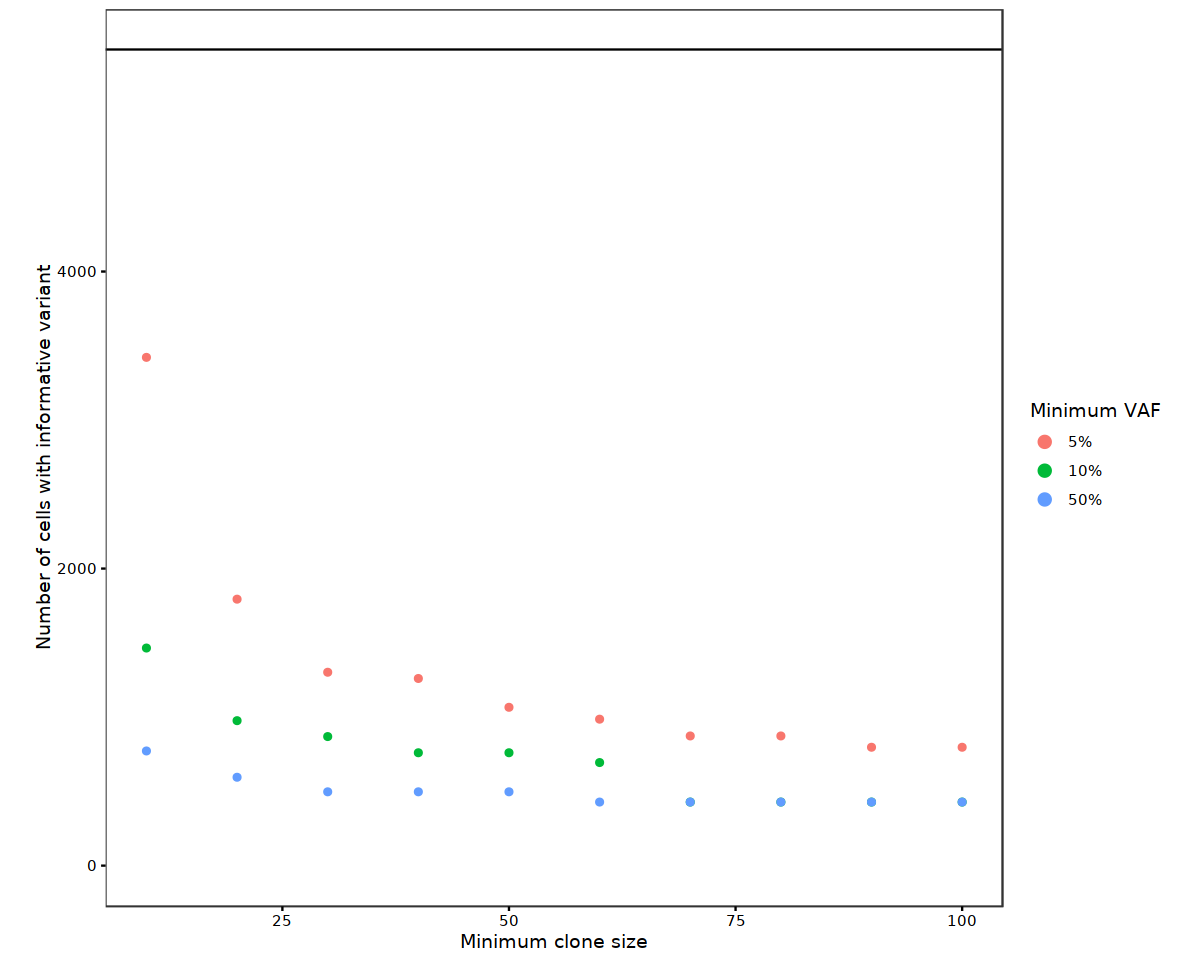

In [511]:
plot_df = conditions.tib %>%
    mutate(min_vaf = str_c(gsub("n", "", min_vaf), "%")) %>%
    mutate(min_vaf = factor(min_vaf, levels = c("1%", "5%", "10%", "50%")))

ggplot(plot_df, aes(x = min_clone_size, y = n_cells, color = min_vaf)) + #, size = n_vois
    geom_hline(yintercept = ncol(af.dm)) +
    geom_point() +
    coord_cartesian(ylim = c(0, ncol(af.dm))) +
    ylab("Number of cells with informative variant") +
    xlab("Minimum clone size") +
    theme_bw() +
    guides(color = guide_legend(override.aes = list(size = 3),
                                title = "Minimum VAF")) +
    theme(aspect.ratio = 1,
          panel.grid = element_blank(),
          axis.ticks = element_line(color = "black"),
          axis.text = element_text(color = "black"))

In [512]:
conditions_subset.tib <- conditions.tib %>% filter(min_clone_size %in% c(10, 20, 50, 100), min_vaf %in% c("n10","n50"))
conditions_subset.tib


min_clone_size,min_vaf,vois,n_vois,cells,n_cells,transitions
<dbl>,<chr>,<list>,<int>,<list>,<int>,<dbl>
10,n10,"152T>C, ....",35,CGGTGCAA....,1465,1
20,n10,"189A>G, ....",12,GAGACTTA....,976,1
50,n10,"7179T>C,....",5,GGATGAGG....,760,1
100,n10,"7179T>C,....",2,AGACAAAC....,428,1
10,n50,"189A>G, ....",15,GAGACTTA....,772,1
20,n50,"204T>C, ....",7,AGACAAAC....,595,1
50,n50,"7179T>C,....",4,AGACAAAC....,497,1
100,n50,"7179T>C,....",2,AGACAAAC....,428,1


## min clone 20 min vaf 10%

In [513]:
# 1. Select variants present in at least 5 cells with a VAF of >10%
# 2. Select variants present in at least 10 cells with a VAF of >10%
# 3. Select variants present in at least 5 cells with a VAF of >50%
# 4. Select variants present in at least 10 cells with a VAF of >50%
a=2
voi.ch <- conditions_subset.tib$vois[[a]]

# List cell IDs that are positive for each of the vois --------------------------------------------
positive_cells.ls <- list()
for (v in voi.ch) {
    # Determine cells with an appreciable VAF
    current_cells.ch <- colnames(af.dm)[af.dm[v,]>1]
    # Save cell IDs for positive cells
    positive_cells.ls[[v]] <- current_cells.ch
}
# Make a tibble of cells marked by each voi
positive_cells.tib <- as_tibble(bind_rows(lapply(positive_cells.ls, function(x) data.frame(cell = x)), .id = "variant")[,2:1]) %>%
    mutate(variant = factor(variant, levels = voi.ch))


# Prepare matrix of variants of interest in cells that are positive for at least one
af_voi.mat <- af.dm[voi.ch,]

af_subset.mat = af_voi.mat[, apply(af_voi.mat, 2, function(x) sum(x>1))>0]

# Customize column order. This is different from the strategy for K562 subclones.
plot_order.mat <- af_subset.mat
for (x in rev(voi.ch)) { plot_order.mat <- plot_order.mat[,order(-plot_order.mat[x,])] }
#for (x in voi.ch) { plot_order.mat <- plot_order.mat[,order(-plot_order.mat[x,])] }

In [514]:
options(repr.plot.width=10, repr.plot.height=8)
meta.tib = as_tibble(meta[rownames(meta) %in% colnames(af.dm),])
meta.tib$cell = rownames(meta[rownames(meta) %in% colnames(af.dm),])
annot.tib = tibble(cell = colnames(plot_order.mat)) %>% left_join(meta.tib, by = "cell") %>% select(CellType)
ct_plot_df = data.frame(annot.tib)
new_ct = intersect(all_ct, unique(meta[common_cells, "CellType"]))
ct_plot_df$CellType = factor(ct_plot_df$CellType, levels = new_ct)
ha <- HeatmapAnnotation(df = ct_plot_df, col = list(CellType = ct_pal))
clone_size_cutoff = conditions_subset.tib$min_clone_size[a]
vaf_cutoff = substr(conditions_subset.tib$min_vaf[a],2,nchar(conditions_subset.tib$min_vaf[a]))
my_title = paste0(sample_name,"(min clone size: ",clone_size_cutoff,", min VAF: ",vaf_cutoff, "%, cell number: ", ncol(plot_order.mat)," cells)")
Heatmap(plot_order.mat, column_title = my_title, 
               col = colorRamp2(seq(0, round(max(plot_order.mat)), length.out = 9),
                                c("#FCFCFC","#FFEDB0","#FFDF5F","#FEC510","#FA8E24","#F14C2B","#DA2828","#BE2222","#A31D1D")),
               show_row_names = T,
               show_column_names = F,
               cluster_columns = F,
               cluster_rows = F,
               row_names_gp = gpar(fontsize = 10),
               name = "AF",
               heatmap_legend_param = list(border = "#000000", grid_height = unit(5, "mm")),
               top_annotation = ha,
               border = T,
               #width = unit(240, "mm"),
               #height = unit(200, "mm"),
               use_raster = T,
               raster_quality = 5)

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



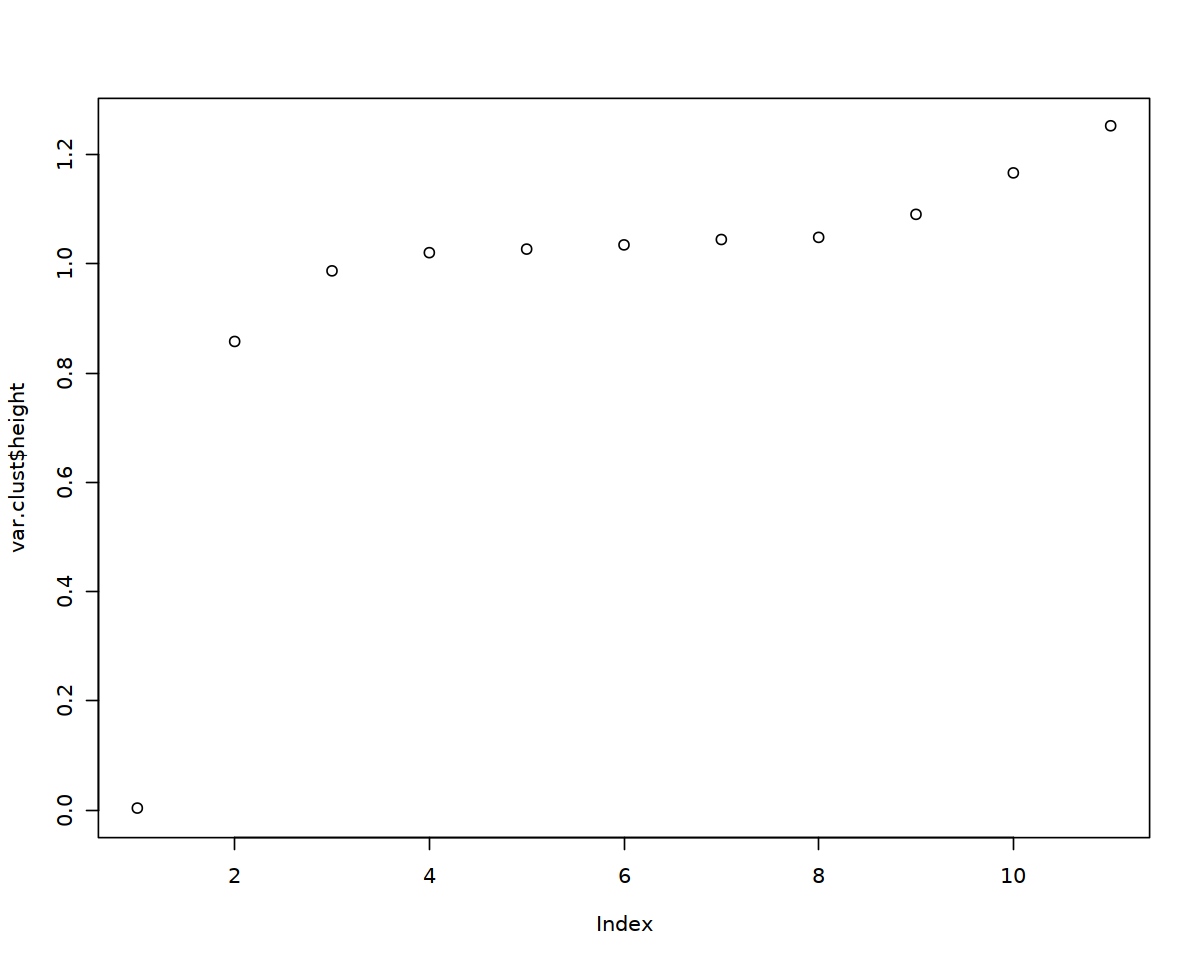

In [515]:
cor.mat = cor(t(af_subset.mat))
#cor.mat
var.clust = hclust(as.dist(1 - cor.mat))

plot(var.clust$height, ylim = c(0, max(var.clust$height)))

In [516]:

ngroups = length(var.clust$height) - sum(var.clust$height<0.8) + 1
Heatmap(cor.mat,
               col = colorRamp2(c(-1,0,1), c("blue", "#DDDDDD", "red")),
               cluster_columns = var.clust,
               cluster_rows = var.clust,
               row_split = switch(ngroups < length(voi.ch), ngroups),
               column_split = switch(ngroups < length(voi.ch), ngroups),
               show_row_dend = F, # without this the visualizationn does not complete
               show_column_dend = F, # without this the visualizationn does not complete
               row_gap = unit(0.5, "mm"),
               column_gap = unit(0.5, "mm"),
               row_names_gp = gpar(fontsize = 10),
               column_names_gp = gpar(fontsize = 10),
               row_title_gp = gpar(fontsize = 10),
               #width = unit(150, "mm"),
               #height = unit(150, "mm"),
               column_title = ngroups)

In [517]:
Groups.tib <- tibble(var = names(cutree(var.clust, k = ngroups)), Cut = cutree(var.clust, k = ngroups))[var.clust$order,]
Groups.tib <- Groups.tib %>% mutate(Group = match(Cut, unique(Cut)))
Groups.tib <- Groups.tib %>% mutate(Group = match(Cut, unique(Cut)))
Groups.tib <- Groups.tib %>% group_by(Group) %>% summarize(vars = toString(var), nvar = n())
GroupIDs.ls <- lapply(str_split(Groups.tib$vars, ", "), function(x) c(sapply(x, function(y) colnames(af.dm[,af.dm[y,] > 1]))))
Groups.tib$ncells <- unlist(lapply(GroupIDs.ls, function(x) length(unique(unlist(x)))))           
Groups.tib <- Groups.tib %>% arrange(desc(ncells), desc(nvar))

identical(sort(voi.ch),sort(unlist(str_split(Groups.tib$vars, ", "))))

#~~~~~~~~~~~~~#
# VAF heatmap #
#~~~~~~~~~~~~~#

# Sort for all variants from the correlation matrix
plot_order.mat <- af_subset.mat[unlist(str_split(Groups.tib$vars, ", ")),]
# Customize column order.
for (x in rev(strsplit(Groups.tib$vars, ", "))) {
    if (length(x) == 1) {
        plot_order.mat <- plot_order.mat[,order(-plot_order.mat[x,])]
    } else {
        plot_order.mat <- plot_order.mat[,order(-colSums(plot_order.mat[x,]))]
    }
}


annot.tib = tibble(cell = colnames(plot_order.mat)) %>% left_join(meta.tib, by = "cell") %>% select(CellType)
ct_plot_df = data.frame(annot.tib)
new_ct = intersect(all_ct, unique(meta[common_cells, "CellType"]))
ct_plot_df$CellType = factor(ct_plot_df$CellType, levels = new_ct)
ha <- HeatmapAnnotation(df = ct_plot_df, col = list(CellType = ct_pal))
                                   
Heatmap(plot_order.mat, column_title = my_title, 
               col = colorRamp2(seq(0, round(max(plot_order.mat)), length.out = 9),
                                c("#FCFCFC","#FFEDB0","#FFDF5F","#FEC510","#FA8E24","#F14C2B","#DA2828","#BE2222","#A31D1D")),
               show_row_names = T,
               show_column_names = F,
               cluster_columns = F,
               cluster_rows = F,
               row_names_gp = gpar(fontsize = 10),
               name = "AF",
               heatmap_legend_param = list(border = "#000000", grid_height = unit(5, "mm")),
               top_annotation = ha,
               border = T,
               #width = unit(100, "mm"),
               #height = unit(100, "mm"),
               use_raster = T,
               raster_quality = 5)

[1] TRUE

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



In [518]:
out_dir = paste0("/syn1/wangxin/work/scATAC/PBMC/", sample_name)
tmp = Groups.tib$vars[Groups.tib$nvar >1]

if (length(tmp) > 0) {Groups.tib$vars[Groups.tib$nvar >1] = sapply(strsplit(tmp, ","), function (x) {
    names(sort(rowMeans(af.dm[unlist(strsplit(gsub(" ", "",x), ",")),]), decreasing = T)[1])
                                                                   }
                                )
                     }
#make a new matrix containing only CIV
CIV = unlist(Groups.tib$vars)
new_plot_mat = plot_order.mat[CIV,]
#sort the new CIV VAF matrix
for (x in rev(strsplit(Groups.tib$vars, ", "))) {
    if (length(x) == 1) {
        new_plot_mat <- new_plot_mat[,order(-new_plot_mat[x,])]
    } else {
        new_plot_mat <- new_plot_mat[,order(-colSums(new_plot_mat[x,]))]
    }
}


right_end = sapply(CIV, function(x) tail(which(new_plot_mat[x,]>0), 1))
right_bor = 0
CIV_idx = c() 
for (i in 1:length(right_end)) {
    if (right_end[i]>right_bor) {
        right_bor = right_end[i]
        CIV_idx = c(CIV_idx, i)
                        }}
right_end = right_end[CIV_idx]
CIV = CIV[CIV_idx]
left_end = c(1, sapply(right_end[1:length(right_end)-1], function(x) x+1))
cell_num = right_end - left_end + 1
CIV = CIV[cell_num>0] #remove CIVs that are misclustered
new_plot_mat = new_plot_mat[CIV,]
                       
new1 = new_plot_mat[CIV[rev(order(cell_num))],]
my_command = paste0("order(", paste0("-new1[", 1:nrow(new1), ",]", collapse = ","), ")")
new2 = new1[, eval(parse(text = my_command))]
new2 = new2[ , colSums(new2)>0]
CIV = rownames(new2)
right_end = sapply(CIV, function(x) tail(which(new2[x,]>0), 1))
left_end = c(1, sapply(right_end[1:length(right_end)-1], function(x) x+1))
cell_num = right_end - left_end + 1                     
clone_info_df = data.frame(Cell = colnames(new2), Clone = rep(CIV, cell_num))
new_plot_mat = new2
                       
CIV_file_name = paste0(out_dir,"/CIV/CIV_clones_", sample_name,".csv")
write.csv(clone_info_df, file = CIV_file_name, quote = F, row.names = F)
message("Clone info has been saved to: ", CIV_file_name)


Clone info has been saved to: /syn1/wangxin/work/scATAC/PBMC/YFL/CIV/CIV_clones_YFL.csv



In [519]:
out_dir = paste0("/syn1/wangxin/work/scATAC/PBMC/",sample_name)
new_plot_mat1 = new_plot_mat/100 

all_mean_ls = c()
all_var_ls = c()
sub_mean_ls = c()
sub_var_ls = c()
all_mv1_ls = c()
sub_mv1_ls = c()

for (x in 1:length(CIV)) {
        #all positive cells
        tmp_vaf_ls = new_plot_mat1[CIV[x],][new_plot_mat1[CIV[x],] >= 0.05]
        all_mean_ls = append(all_mean_ls, mean(tmp_vaf_ls))
        all_var_ls = append(all_var_ls, var(tmp_vaf_ls))
        mv1 = mean(tmp_vaf_ls)/(1+var(tmp_vaf_ls))
        all_mv1_ls = append(all_mv1_ls, mv1)
        #sub cells
        tmp_vaf_ls = new_plot_mat1[CIV[x],clone_info_df$Cell[clone_info_df$Clone == CIV[x]]]
        tmp_vaf_ls = tmp_vaf_ls[tmp_vaf_ls >= 0.05]
        sub_mean_ls = append(sub_mean_ls, mean(tmp_vaf_ls))
        sub_var_ls = append(sub_var_ls, var(tmp_vaf_ls))
        mv1 = mean(tmp_vaf_ls)/(1+var(tmp_vaf_ls))
        sub_mv1_ls = append(sub_mv1_ls, mv1)
}

meanvar_df_all = data.frame("Clone" = CIV, "Mean" = all_mean_ls, "Variance" = all_var_ls, "MV1" = all_mv1_ls, "Sim" = rep(sample_name, length(CIV)), "Method" = rep("All", length(CIV)))
meanvar_df_sub= data.frame("Clone" = CIV, "Mean" = sub_mean_ls, "Variance" = sub_var_ls, "MV1" = sub_mv1_ls, "Sim" = rep(sample_name, length(CIV)),  "Method" = rep("Sub", length(CIV)))


meanvar_df = rbind(meanvar_df_all, meanvar_df_sub)
meanvar_file_name = paste0(out_dir,"/CIV/meanvar_CIV_", sample_name, ".csv")
write.csv(meanvar_df, file = meanvar_file_name, quote = F, row.names = F)
message("Mean, variance and MV1 info have been saved to: ", meanvar_file_name)


Mean, variance and MV1 info have been saved to: /syn1/wangxin/work/scATAC/PBMC/YFL/CIV/meanvar_CIV_YFL.csv



In [520]:
col_pal = colorRamp2(c(0, 1), c( "white", "navyblue"))
row_annot <- rowAnnotation(
  df = data.frame(CIV_score = sub_mv1_ls),
  col = list(CIV_score = col_pal), annotation_legend_param = list(border = "#000000"))

annot.tib = tibble(cell = colnames(new_plot_mat)) %>% left_join(meta.tib, by = "cell") %>% select(CellType)
ct_plot_df = data.frame(annot.tib)
new_ct = intersect(all_ct, unique(meta[common_cells, "CellType"]))
ct_plot_df$CellType = factor(ct_plot_df$CellType, levels = new_ct)
ha <- HeatmapAnnotation(df = ct_plot_df, col = list(CellType = ct_pal))
                                   
htmap_p = Heatmap(new_plot_mat, column_title = my_title, 
               col = colorRamp2(seq(0, 100, length.out = 9),
                                c("#FCFCFC","#FFEDB0","#FFDF5F","#FEC510","#FA8E24","#F14C2B","#DA2828","#BE2222","#A31D1D")),
               show_row_names = T,
               show_column_names = F,
               cluster_columns = F,
               cluster_rows = F,
               row_names_gp = gpar(fontsize = 10),
               name = "AF",
               heatmap_legend_param = list(border = "#000000", grid_height = unit(5, "mm")),
               top_annotation = ha,
                  left_annotation = row_annot,
               border = T,
               #width = unit(100, "mm"),
               #height = unit(100, "mm"),
               use_raster = T,
               raster_quality = 5)
htmap_p

heatmap_name = paste0(out_dir,"/CIV/",sample_name,"_CIV_heatmap.pdf")
pdf(heatmap_name, height = 2.645, width = 3.5)
htmap_p
dev.off()
message(paste0("CIV heatmaps have been saved to: ", heatmap_name))


'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



png 
  2

CIV heatmaps have been saved to: /syn1/wangxin/work/scATAC/PBMC/YFL/CIV/YFL_CIV_heatmap.pdf



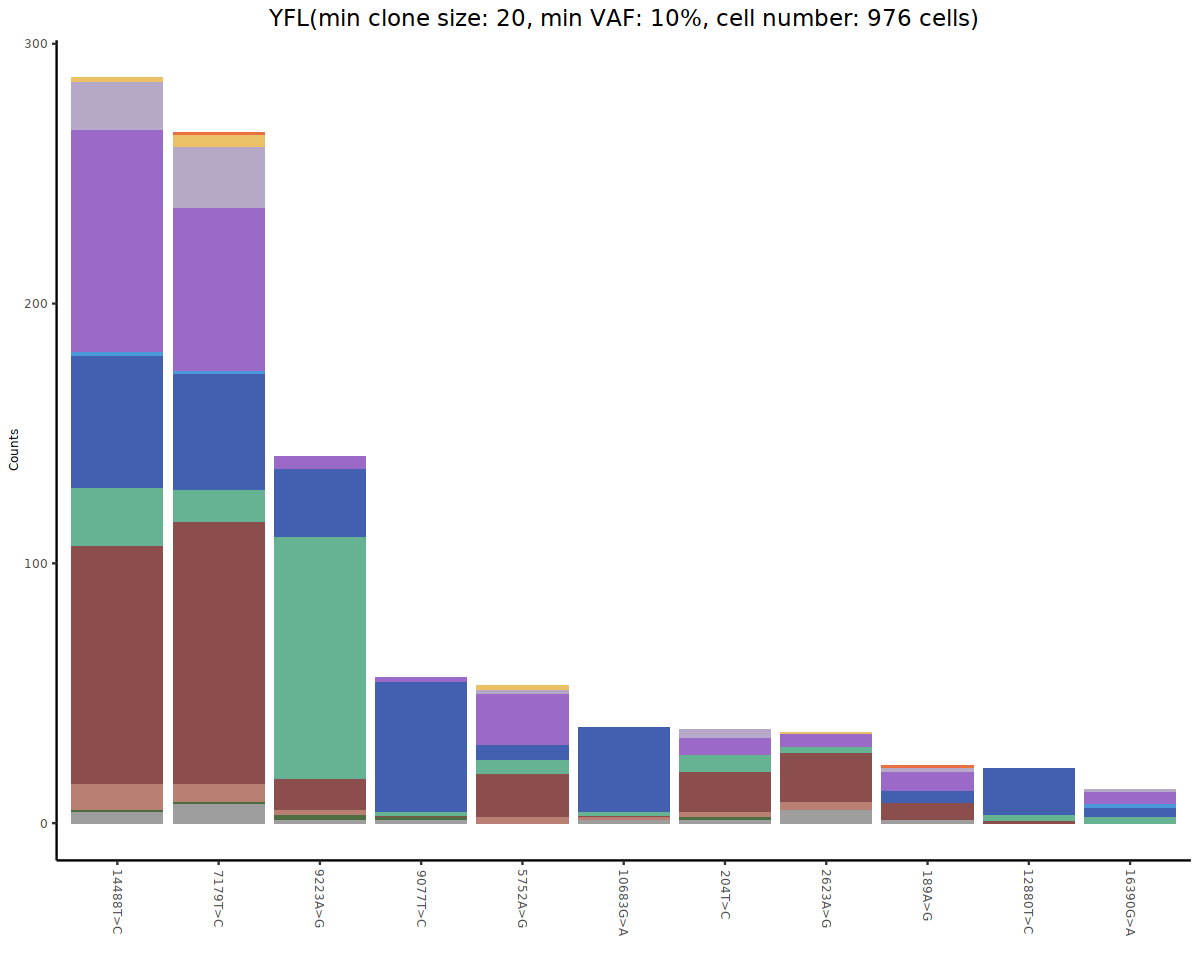

CIV heatmaps have been saved to: /syn1/wangxin/work/scATAC/PBMC/YFL/CIV/YFL_cellType_composition.pdf



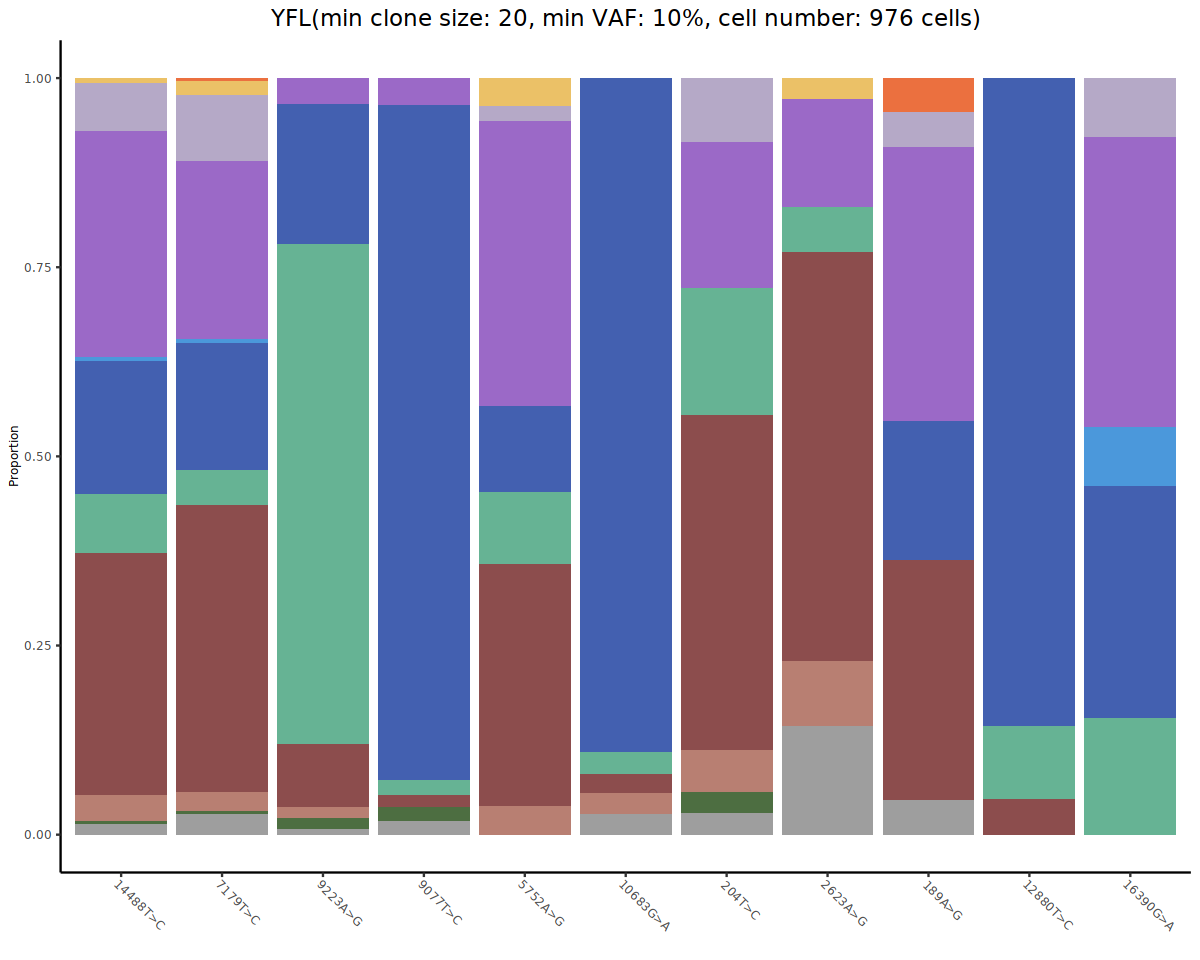

In [521]:

ct_df = data.frame(matrix(nrow=0, ncol=4)) 
for (i in rownames(new_plot_mat)) {
    pos_cells = clone_info_df[,"Cell"][clone_info_df$Clone == i]
    tmp_ct_df = as.data.frame(table(meta[pos_cells,"CellType"]))
    tmp_ct_df$Proportion = tmp_ct_df[,2]/sum(tmp_ct_df[,2])
    tmp_ct_df$Clone = i
    ct_df = rbind(ct_df, tmp_ct_df)
}
colnames(ct_df) = c("CellType", "Counts", "Proportion", "Clone")
ct_df$CellType = factor(ct_df$CellType, levels = new_ct)
ct_df$Clone = factor(ct_df$Clone, levels = rownames(new_plot_mat) )


p3 = ggplot(ct_df, aes(x=Clone, y=Counts, fill=CellType)) + geom_bar(stat = "identity") + labs(title = my_title) + theme_classic() +
        theme(plot.title=element_text(hjust=0.5), axis.text = element_text(size = 7), axis.title = element_text(size=7),
        axis.text.x = element_text(angle = 270, hjust = 0.1, vjust = 0.5), legend.position = "none") + scale_fill_manual(values=ct_pal) + xlab("")
p3
p4 = ggplot(ct_df, aes(x=Clone, y=Proportion, fill=CellType)) + geom_bar(stat = "identity") + labs(title = my_title) + theme_classic() +
        theme(plot.title=element_text(hjust=0.5), axis.text = element_text(size = 7), axis.title = element_text(size=7),
        axis.text.x = element_text(angle = 315, hjust = 0.1, vjust = 0.5), legend.position = "none") + scale_fill_manual(values=ct_pal) + xlab("")
p4

bar_name = paste0(out_dir,"/CIV/",sample_name,"_cellType_composition.pdf")
ggsave(p4, filename = bar_name, height = 2.5, width = 2)
message(paste0("CIV heatmaps have been saved to: ", bar_name))

In [391]:
subset(ct_df, subset = Clone == "9077T>C" & CellType == "CD8T_memory")

,CellType,Counts,Proportion,Clone
,<fct>,<int>,<dbl>,<fct>
31,CD8T_memory,50,0.8928571,9077T>C


In [522]:
subset(ct_df, subset = Clone == "9223A>G" & CellType == "NK")

,CellType,Counts,Proportion,Clone
,<fct>,<int>,<dbl>,<fct>
27,NK,93,0.6595745,9223A>G


In [394]:
umap_plot_df = meta[colnames(af.dm),]
nrow(umap_plot_df)

[1] 5492

CIV heatmaps have been saved to: /syn1/wangxin/work/scATAC/PBMC/YFL/CIV/YFL_umap.pdf



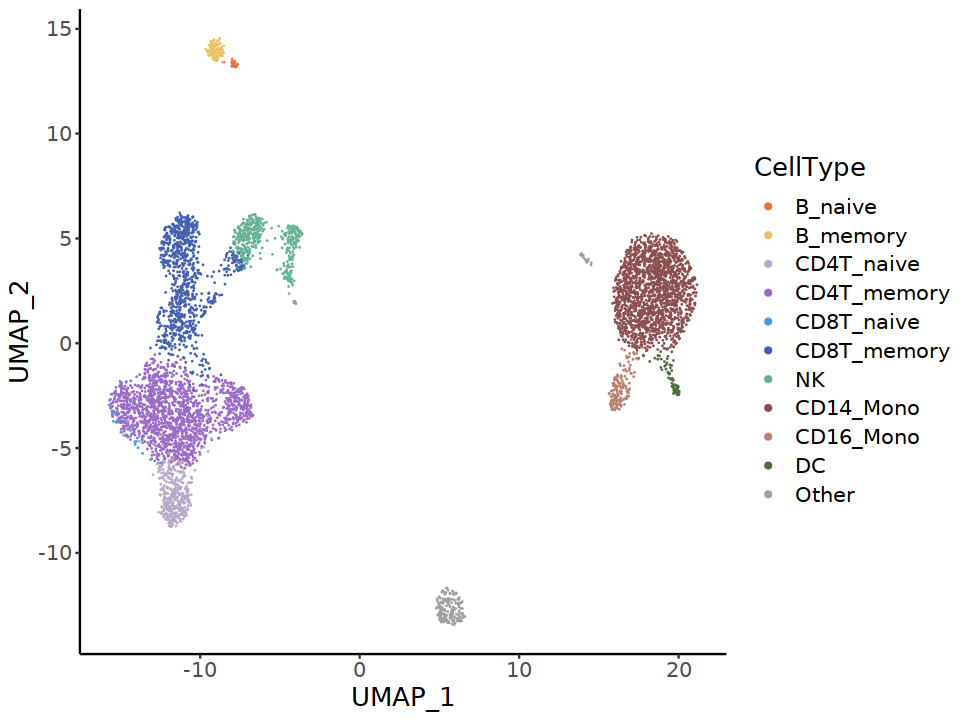

In [221]:
###here!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
options(repr.plot.width=8, repr.plot.height=6)

umap_plot_df = meta[colnames(af.dm),]
umap_plot_df$CellType = factor(umap_plot_df$CellType, levels = new_ct)
umap_p = ggplot(umap_plot_df, aes(x=UMAP_1, y=UMAP_2, color = CellType)) + geom_point(size=0.5, stroke = 0) + theme_classic() + scale_color_manual(values=ct_pal) + theme(text = element_text(size=15)) + 
    guides(colour = guide_legend(override.aes = list(size=2)))
umap_p
umap_pdf_name = paste0(out_dir,"/CIV/", sample_name,"_umap.pdf")
ggsave(umap_pdf_name, umap_p, height = 2.3, width = 4)
message(paste0("CIV heatmaps have been saved to: ", umap_pdf_name))

In [204]:
plot_ls=list()
for (i in rownames(new_plot_mat)) {
    cells = clone_info_df[clone_info_df$Clone == i, "Cell"]
    tmp_umap_df = umap_plot_df
    tmp_umap_df$VAF = 0
    tmp_umap_df[cells,"VAF"] = new_plot_mat[i, cells]
    tmp_umap_df$size = 0.4
    tmp_umap_df[cells,"size"] = 0.5
    #tmp_umap_df$trans = 0.3
    #tmp_umap_df[cells,"trans"] = 1
    tmp_umap_df = tmp_umap_df[order(tmp_umap_df$VAF),]
    plot_ls[[i]] = ggplot(tmp_umap_df, aes(x=UMAP_1, y=UMAP_2, color = VAF)) + geom_point(size=tmp_umap_df$size, stroke = 0) + scale_colour_gradient(low="gray", high ="red") + theme_classic() + scale_color_continuous(low="grey", high="red") + 
        theme(legend.position = "none") + labs(title = i)
    #plot_ls[[i]] = ggplot(tmp_umap_df, aes(x=UMAP1, y=UMAP2, color = VAF)) + geom_point(size=tmp_umap_df$size, alpha = tmp_umap_df$trans) + scale_colour_gradient(low="grey", high ="red") + theme_classic() + scale_color_continuous(low="grey", high="red") + 
    #    theme(legend.position = "none") + labs(title = i)
    #break
}
fn = paste0("/syn1/wangxin/work/scATAC/PBMC/",sample_name,"/CIV/pooled_umap_distribution_min_vaf_", vaf_cutoff, "_min_clone_", clone_size_cutoff,".pdf")
ggexport(plotlist = plot_ls, nrow = 5, ncol =5, filename = fn, width = 10, height = 10)

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is

In [245]:
sample_name

[1] "THQ"

# Donor2 - THQ - Figs

In [359]:
all_ct = c("B_naive", "B_memory", "B_plasma", "CD4T_naive", "CD4T_memory", "CD8T_naive", "CD8T_memory", "NK", "CD14_Mono", "CD16_Mono", "NC_Mono", "DC", "Other")
ct_pal = c("#EB703F", "#EBC167", "#D4D645", "#B5A9C7", "#9B69C7", "#4B98DB", "#4360B0", "#66B394", "#8C4D4D", "#B87F72", "#806f69", "#4D6E41", "808080")
names(ct_pal) = all_ct

In [360]:
sample_name = "THQ"
main_dir = paste0("/data3/wangxin/PBMC/", sample_name, "/outs/")
setwd(main_dir)
df = read.csv(paste0(main_dir, sample_name, "_mtSNV_final.csv"), row.names = 1, check.names = F)

meta = read.csv(paste0("/syn1/wangxin/work/scATAC/PBMC/ArchR_out/",sample_name, "/", sample_name,"_meta_info.csv"), row.names = 1, check.names = F, header = T)
rownames(meta) = gsub(paste0(sample_name,"#"), "", rownames(meta))
common_cells = intersect(rownames(meta), colnames(df))
df = df[,common_cells]
af.dm = as.matrix(df*100)

vars.tib <- tibble(var = rownames(af.dm),
                   mean_af = rowMeans(af.dm))

start_time <- Sys.time()
vars.tib = mutate(vars.tib, n0 = apply(af.dm, 1, function(x) sum(x == 0)))
vars.tib = mutate(vars.tib, n1 = apply(af.dm, 1, function(x) sum(x >= 1)))
vars.tib = mutate(vars.tib, n5 = apply(af.dm, 1, function(x) sum(x >= 5)))
vars.tib = mutate(vars.tib, n10 = apply(af.dm, 1, function(x) sum(x >= 10)))
vars.tib = mutate(vars.tib, n50 = apply(af.dm, 1, function(x) sum(x >= 50)))
Sys.time() - start_time
                                       

Time difference of 3.03513 secs

In [361]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
# Test different variant selection thresholds #
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

# Specify variant selection thresholds to test. voi = variant of interest
conditions.tib <- tibble(min_clone_size = rep(seq(10, 50, by = 10), 3),
                         min_vaf = rep(c( "n5", "n10", "n50"), each = 5),
                         vois = NA,
                         n_vois = NA,
                         cells = NA,
                         n_cells = NA,
                         transitions = NA)
vois.ls <- vector(mode = "list", length = nrow(conditions.tib))
cells.ls <- vector(mode = "list", length = nrow(conditions.tib))

vars_filter.tib <- vars.tib %>% filter(n0 > 0.9*ncol(af.dm))
# Fill in conditions.tib
for (x in 1:nrow(conditions.tib)) {
    print(x)
    
    min_clone_size <- conditions.tib$min_clone_size[x]
    min_vaf <- conditions.tib$min_vaf[x]

    # Define variants of which the number of cells exceeding min_vaf is higher than min_clone_size
    voi.ch <- vars_filter.tib$var[vars_filter.tib[[min_vaf]] >= min_clone_size]
    #print(voi.ch)
    # Which cells are positive for at least one of the variants?
    af_subset.dm <- af.dm[voi.ch,]
    positive_cells <- colnames( af_subset.dm[,colSums(af_subset.dm > 1) > 0 ] ) # changed the original code
    
    # Add information to summary table
    conditions.tib[x,"n_vois"] <- length(voi.ch)
    conditions.tib[x,"n_cells"] <- length(positive_cells)
    # Transitions vs. transversions
    conditions.tib[x,"transitions"] <- mean( str_count(voi.ch, "G>A|A>G|C>T|T>C") )
    
    # Save variants and cells for these parameters
    vois.ls[[x]] <- voi.ch
    #print(positive_cells)
    cells.ls[[x]] <- positive_cells
}
conditions.tib$vois <- vois.ls
conditions.tib$cells <- cells.ls
conditions.tib

[1] 1
[1] 2
[1] 3
[1] 4
[1] 5
[1] 6
[1] 7
[1] 8
[1] 9
[1] 10
[1] 11
[1] 12
[1] 13
[1] 14
[1] 15


min_clone_size,min_vaf,vois,n_vois,cells,n_cells,transitions
<dbl>,<chr>,<list>,<int>,<list>,<int>,<dbl>
10,n5,"75G>A, 1....",304,TTACGGAG....,3020,0.9671053
20,n5,"146T>C, ....",50,GCATGATT....,1704,0.9200000
30,n5,"152T>C, ....",24,GCATGATT....,1314,0.9166667
40,n5,"152T>C, ....",16,GCATGATT....,1132,0.9375000
50,n5,"152T>C, ....",14,GCATGATT....,1056,0.9285714
10,n10,"146T>C, ....",40,GCATGATT....,1437,0.9500000
20,n10,"152T>C, ....",18,GCATGATT....,1002,0.9444444
30,n10,"152T>C, ....",13,GCATGATT....,898,1.0000000
40,n10,"152T>C, ....",7,GCATGATT....,696,1.0000000


In [362]:
plot_df = conditions.tib %>%
    mutate(min_vaf = str_c(gsub("n", "", min_vaf), "%")) %>%
    mutate(min_vaf = factor(min_vaf, levels = c("1%", "5%", "10%", "50%")))

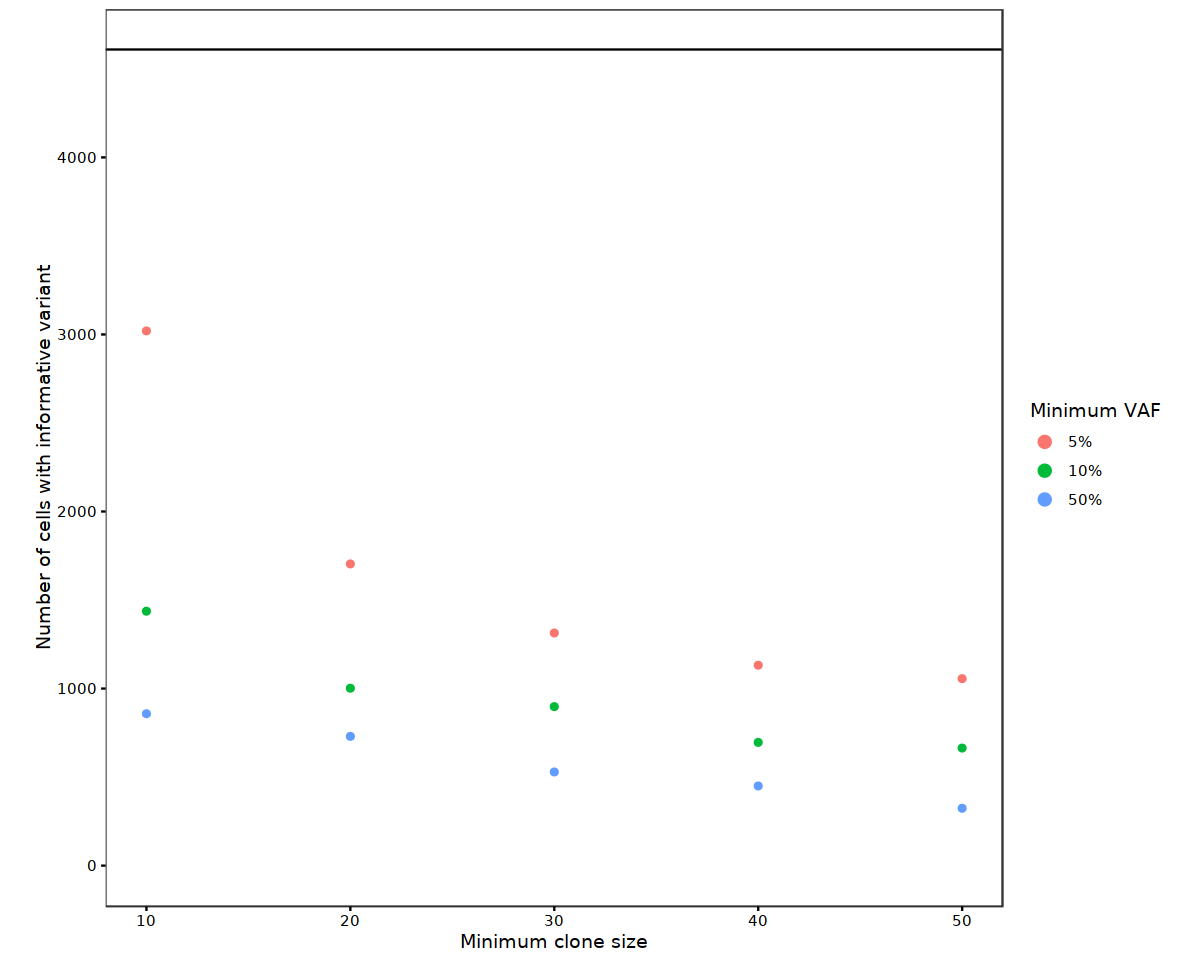

In [363]:
plot_df = conditions.tib %>%
    mutate(min_vaf = str_c(gsub("n", "", min_vaf), "%")) %>%
    mutate(min_vaf = factor(min_vaf, levels = c("1%", "5%", "10%", "50%")))

ggplot(plot_df, aes(x = min_clone_size, y = n_cells, color = min_vaf)) + #, size = n_vois
    geom_hline(yintercept = ncol(af.dm)) +
    geom_point() +
    coord_cartesian(ylim = c(0, ncol(af.dm))) +
    ylab("Number of cells with informative variant") +
    xlab("Minimum clone size") +
    theme_bw() +
    guides(color = guide_legend(override.aes = list(size = 3),
                                title = "Minimum VAF")) +
    theme(aspect.ratio = 1,
          panel.grid = element_blank(),
          axis.ticks = element_line(color = "black"),
          axis.text = element_text(color = "black"))

In [364]:
conditions_subset.tib <- conditions.tib %>% filter(min_clone_size %in% c(10, 20, 50), min_vaf %in% c("n10","n50"))
conditions_subset.tib


min_clone_size,min_vaf,vois,n_vois,cells,n_cells,transitions
<dbl>,<chr>,<list>,<int>,<list>,<int>,<dbl>
10,n10,"146T>C, ....",40,GCATGATT....,1437,0.9500000
20,n10,"152T>C, ....",18,GCATGATT....,1002,0.9444444
50,n10,"152T>C, ....",6,GCATGATT....,664,1.0000000
10,n50,"152T>C, ....",21,CTAACTTG....,858,0.9523810
20,n50,"152T>C, ....",14,CTAACTTG....,730,1.0000000
50,n50,"152T>C, ....",3,AAGGAGCA....,324,1.0000000


## min clone 20 min vaf 10%

In [365]:
# 1. Select variants present in at least 5 cells with a VAF of >10%
# 2. Select variants present in at least 10 cells with a VAF of >10%
# 3. Select variants present in at least 5 cells with a VAF of >50%
# 4. Select variants present in at least 10 cells with a VAF of >50%
a=2
voi.ch <- conditions_subset.tib$vois[[a]]

# List cell IDs that are positive for each of the vois --------------------------------------------
positive_cells.ls <- list()
for (v in voi.ch) {
    # Determine cells with an appreciable VAF
    current_cells.ch <- colnames(af.dm)[af.dm[v,]>1]
    # Save cell IDs for positive cells
    positive_cells.ls[[v]] <- current_cells.ch
}
# Make a tibble of cells marked by each voi
positive_cells.tib <- as_tibble(bind_rows(lapply(positive_cells.ls, function(x) data.frame(cell = x)), .id = "variant")[,2:1]) %>%
    mutate(variant = factor(variant, levels = voi.ch))


# Prepare matrix of variants of interest in cells that are positive for at least one
af_voi.mat <- af.dm[voi.ch,]

af_subset.mat = af_voi.mat[, apply(af_voi.mat, 2, function(x) sum(x>1))>0]

# Customize column order. This is different from the strategy for K562 subclones.
plot_order.mat <- af_subset.mat
for (x in rev(voi.ch)) { plot_order.mat <- plot_order.mat[,order(-plot_order.mat[x,])] }
#for (x in voi.ch) { plot_order.mat <- plot_order.mat[,order(-plot_order.mat[x,])] }

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



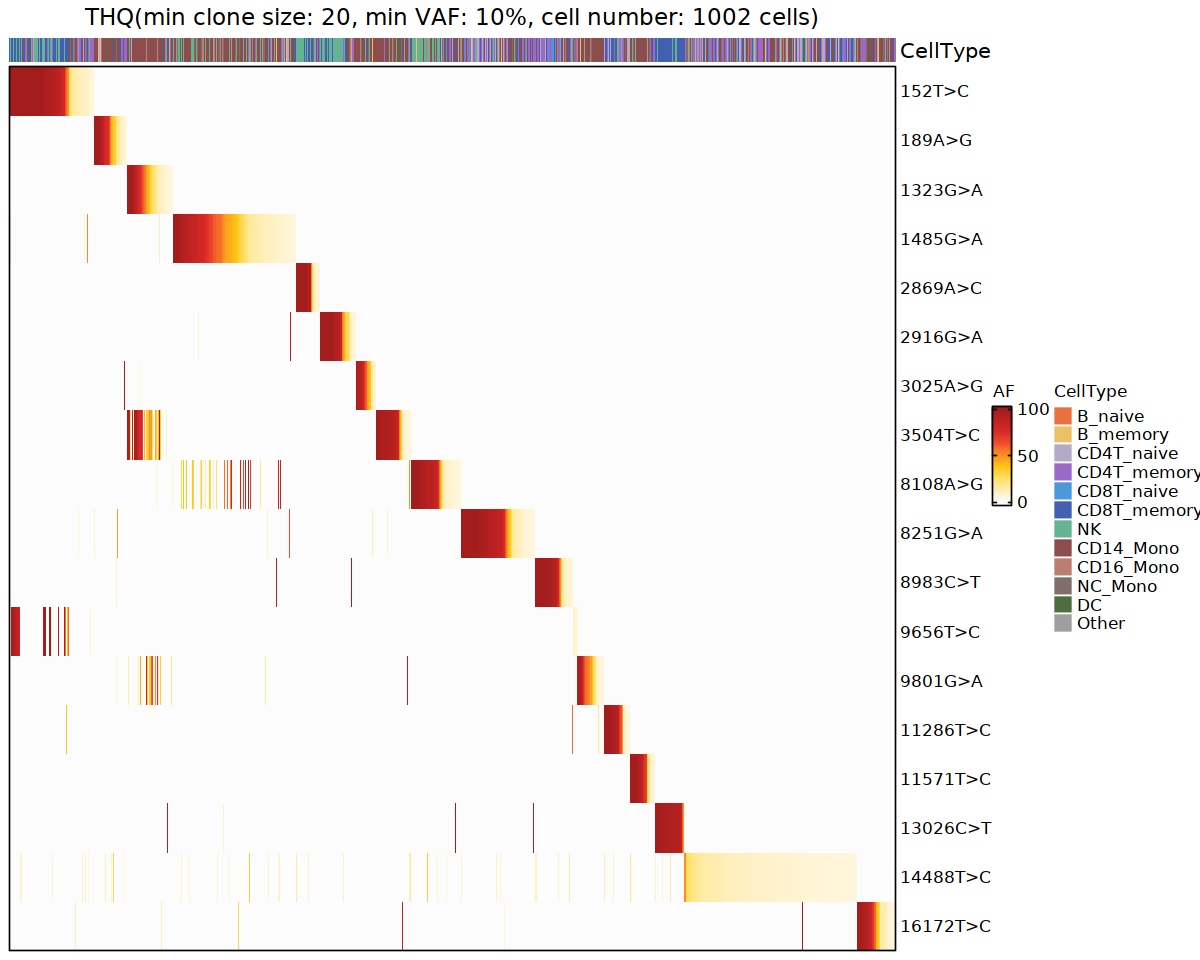

In [366]:
options(repr.plot.width=10, repr.plot.height=8)
meta.tib = as_tibble(meta[rownames(meta) %in% colnames(af.dm),])
meta.tib$cell = rownames(meta[rownames(meta) %in% colnames(af.dm),])
annot.tib = tibble(cell = colnames(plot_order.mat)) %>% left_join(meta.tib, by = "cell") %>% select(CellType)
ct_plot_df = data.frame(annot.tib)
new_ct = intersect(all_ct, unique(meta[common_cells, "CellType"]))
ct_plot_df$CellType = factor(ct_plot_df$CellType, levels = new_ct)
ha <- HeatmapAnnotation(df = ct_plot_df, col = list(CellType = ct_pal))
clone_size_cutoff = conditions_subset.tib$min_clone_size[a]
vaf_cutoff = substr(conditions_subset.tib$min_vaf[a],2,nchar(conditions_subset.tib$min_vaf[a]))
my_title = paste0(sample_name,"(min clone size: ",clone_size_cutoff,", min VAF: ",vaf_cutoff, "%, cell number: ", ncol(plot_order.mat)," cells)")
Heatmap(plot_order.mat, column_title = my_title, 
               col = colorRamp2(seq(0, round(max(plot_order.mat)), length.out = 9),
                                c("#FCFCFC","#FFEDB0","#FFDF5F","#FEC510","#FA8E24","#F14C2B","#DA2828","#BE2222","#A31D1D")),
               show_row_names = T,
               show_column_names = F,
               cluster_columns = F,
               cluster_rows = F,
               row_names_gp = gpar(fontsize = 10),
               name = "AF",
               heatmap_legend_param = list(border = "#000000", grid_height = unit(5, "mm")),
               top_annotation = ha,
               border = T,
               #width = unit(240, "mm"),
               #height = unit(200, "mm"),
               use_raster = T,
               raster_quality = 5)

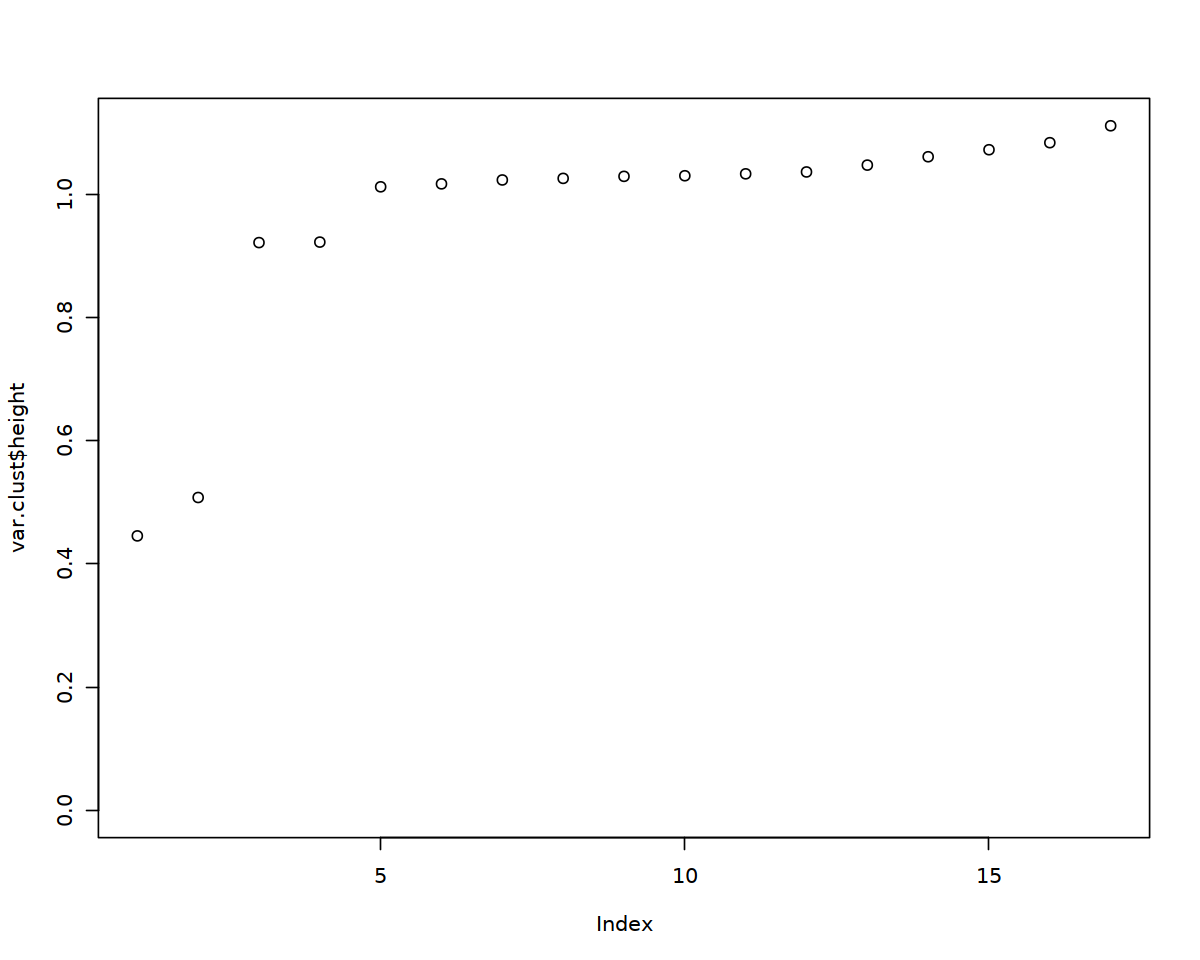

In [367]:
cor.mat = cor(t(af_subset.mat))
#cor.mat
var.clust = hclust(as.dist(1 - cor.mat))

plot(var.clust$height, ylim = c(0, max(var.clust$height)))

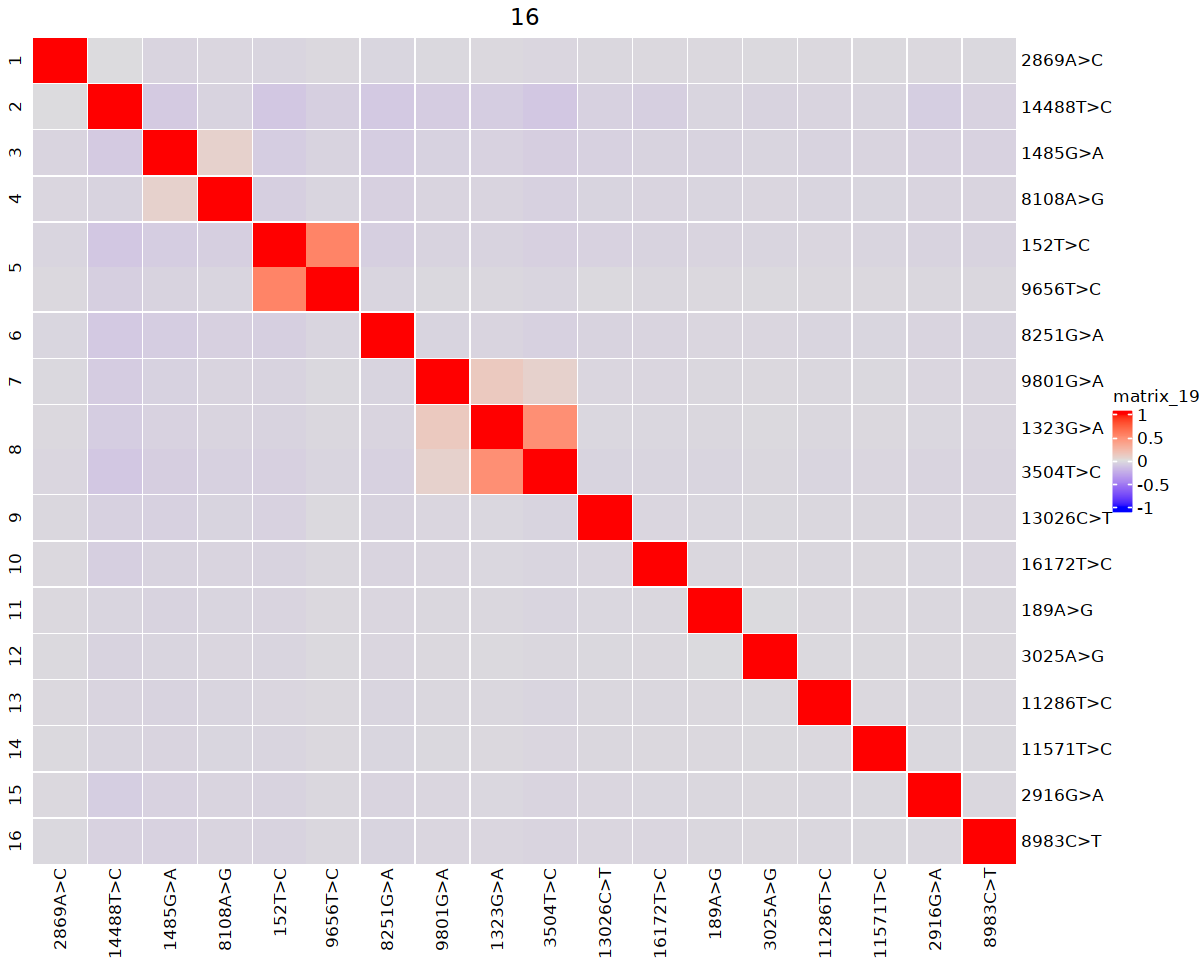

In [368]:

ngroups = length(var.clust$height) - sum(var.clust$height<0.8) + 1
Heatmap(cor.mat,
               col = colorRamp2(c(-1,0,1), c("blue", "#DDDDDD", "red")),
               cluster_columns = var.clust,
               cluster_rows = var.clust,
               row_split = switch(ngroups < length(voi.ch), ngroups),
               column_split = switch(ngroups < length(voi.ch), ngroups),
               show_row_dend = F, # without this the visualizationn does not complete
               show_column_dend = F, # without this the visualizationn does not complete
               row_gap = unit(0.5, "mm"),
               column_gap = unit(0.5, "mm"),
               row_names_gp = gpar(fontsize = 10),
               column_names_gp = gpar(fontsize = 10),
               row_title_gp = gpar(fontsize = 10),
               #width = unit(150, "mm"),
               #height = unit(150, "mm"),
               column_title = ngroups)

[1] TRUE

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



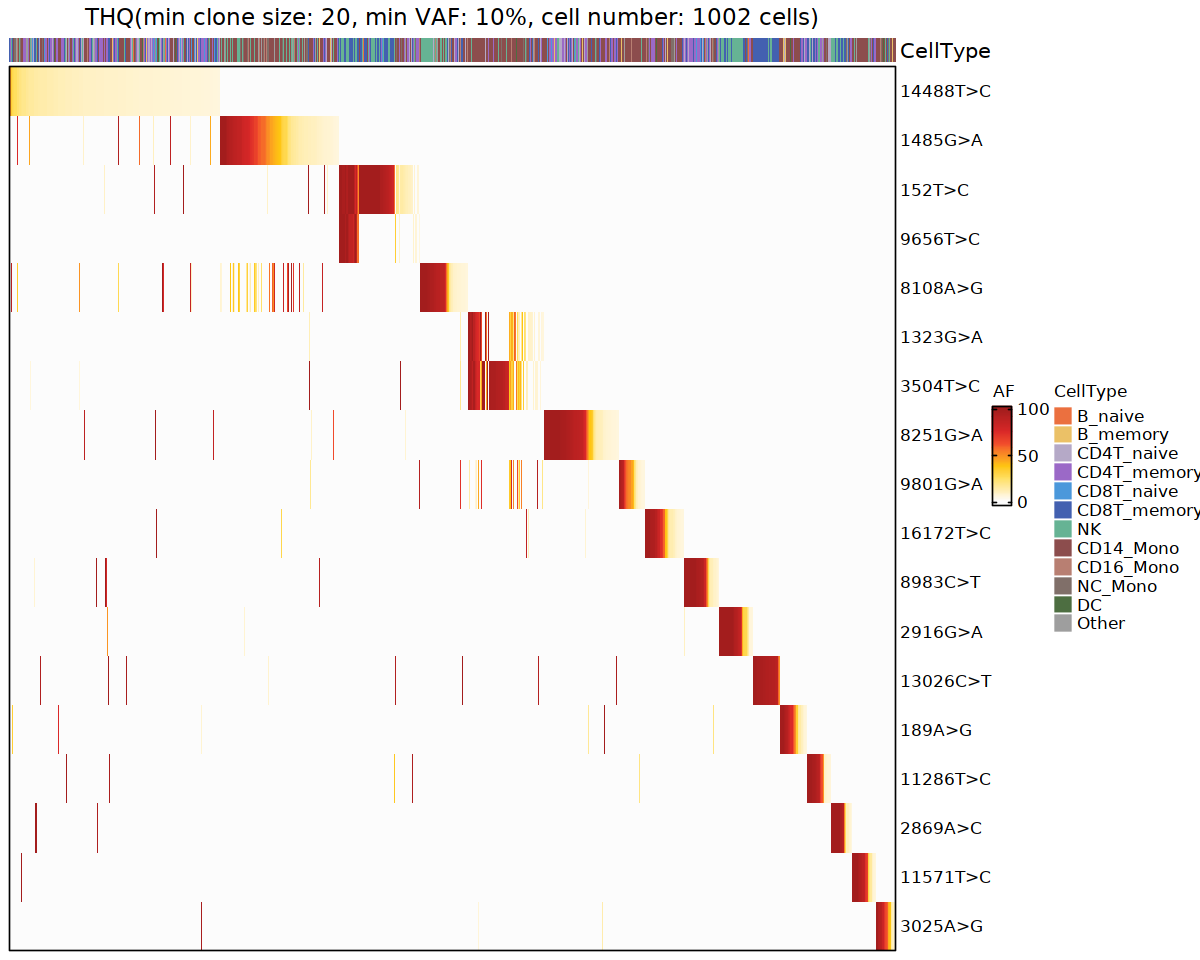

In [369]:
Groups.tib <- tibble(var = names(cutree(var.clust, k = ngroups)), Cut = cutree(var.clust, k = ngroups))[var.clust$order,]
Groups.tib <- Groups.tib %>% mutate(Group = match(Cut, unique(Cut)))
Groups.tib <- Groups.tib %>% mutate(Group = match(Cut, unique(Cut)))
Groups.tib <- Groups.tib %>% group_by(Group) %>% summarize(vars = toString(var), nvar = n())
GroupIDs.ls <- lapply(str_split(Groups.tib$vars, ", "), function(x) c(sapply(x, function(y) colnames(af.dm[,af.dm[y,] > 1]))))
Groups.tib$ncells <- unlist(lapply(GroupIDs.ls, function(x) length(unique(unlist(x)))))           
Groups.tib <- Groups.tib %>% arrange(desc(ncells), desc(nvar))

identical(sort(voi.ch),sort(unlist(str_split(Groups.tib$vars, ", "))))

#~~~~~~~~~~~~~#
# VAF heatmap #
#~~~~~~~~~~~~~#

# Sort for all variants from the correlation matrix
plot_order.mat <- af_subset.mat[unlist(str_split(Groups.tib$vars, ", ")),]
# Customize column order.
for (x in rev(strsplit(Groups.tib$vars, ", "))) {
    if (length(x) == 1) {
        plot_order.mat <- plot_order.mat[,order(-plot_order.mat[x,])]
    } else {
        plot_order.mat <- plot_order.mat[,order(-colSums(plot_order.mat[x,]))]
    }
}


annot.tib = tibble(cell = colnames(plot_order.mat)) %>% left_join(meta.tib, by = "cell") %>% select(CellType)
ct_plot_df = data.frame(annot.tib)
new_ct = intersect(all_ct, unique(meta[common_cells, "CellType"]))
ct_plot_df$CellType = factor(ct_plot_df$CellType, levels = new_ct)
ha <- HeatmapAnnotation(df = ct_plot_df, col = list(CellType = ct_pal))
                                   
Heatmap(plot_order.mat, column_title = my_title, 
               col = colorRamp2(seq(0, round(max(plot_order.mat)), length.out = 9),
                                c("#FCFCFC","#FFEDB0","#FFDF5F","#FEC510","#FA8E24","#F14C2B","#DA2828","#BE2222","#A31D1D")),
               show_row_names = T,
               show_column_names = F,
               cluster_columns = F,
               cluster_rows = F,
               row_names_gp = gpar(fontsize = 10),
               name = "AF",
               heatmap_legend_param = list(border = "#000000", grid_height = unit(5, "mm")),
               top_annotation = ha,
               border = T,
               #width = unit(100, "mm"),
               #height = unit(100, "mm"),
               use_raster = T,
               raster_quality = 5)

In [370]:
out_dir = paste0("/syn1/wangxin/work/scATAC/PBMC/", sample_name)

tmp = Groups.tib$vars[Groups.tib$nvar >1]

if (length(tmp) > 0) {Groups.tib$vars[Groups.tib$nvar >1] = sapply(strsplit(tmp, ","), function (x) {
    names(sort(rowMeans(af.dm[unlist(strsplit(gsub(" ", "",x), ",")),]), decreasing = T)[1])
                                                                   }
                                )
                     }
#make a new matrix containing only CIV
CIV = unlist(Groups.tib$vars)
new_plot_mat = plot_order.mat[CIV,]
#sort the new CIV VAF matrix
for (x in rev(strsplit(Groups.tib$vars, ", "))) {
    if (length(x) == 1) {
        new_plot_mat <- new_plot_mat[,order(-new_plot_mat[x,])]
    } else {
        new_plot_mat <- new_plot_mat[,order(-colSums(new_plot_mat[x,]))]
    }
}


right_end = sapply(CIV, function(x) tail(which(new_plot_mat[x,]>0), 1))
right_bor = 0
CIV_idx = c() 
for (i in 1:length(right_end)) {
    if (right_end[i]>right_bor) {
        right_bor = right_end[i]
        CIV_idx = c(CIV_idx, i)
                        }}
right_end = right_end[CIV_idx]
CIV = CIV[CIV_idx]
left_end = c(1, sapply(right_end[1:length(right_end)-1], function(x) x+1))
cell_num = right_end - left_end + 1
CIV = CIV[cell_num>0] #remove CIVs that are misclustered
new_plot_mat = new_plot_mat[CIV,]
                       
new1 = new_plot_mat[CIV[rev(order(cell_num))],]
my_command = paste0("order(", paste0("-new1[", 1:nrow(new1), ",]", collapse = ","), ")")
new2 = new1[, eval(parse(text = my_command))]
new2 = new2[ , colSums(new2)>0]
CIV = rownames(new2)
right_end = sapply(CIV, function(x) tail(which(new2[x,]>0), 1))
left_end = c(1, sapply(right_end[1:length(right_end)-1], function(x) x+1))
cell_num = right_end - left_end + 1                     
clone_info_df = data.frame(Cell = colnames(new2), Clone = rep(CIV, cell_num))

CIV_file_name = paste0(out_dir,"/CIV/CIV_clones_", sample_name, "_.csv")
write.csv(clone_info_df, file = CIV_file_name, quote = F, row.names = F)
message("Clone info has been saved to: ", CIV_file_name)
new_plot_mat = new2


Clone info has been saved to: /syn1/wangxin/work/scATAC/PBMC/THQ/CIV/CIV_clones_THQ_.csv



In [371]:
out_dir = paste0("/syn1/wangxin/work/scATAC/PBMC/",sample_name)
new_plot_mat1 = new_plot_mat/100 

all_mean_ls = c()
all_var_ls = c()
sub_mean_ls = c()
sub_var_ls = c()
all_mv1_ls = c()
sub_mv1_ls = c()

for (x in 1:length(CIV)) {
        #all positive cells
        tmp_vaf_ls = new_plot_mat1[CIV[x],][new_plot_mat1[CIV[x],] >= 0.05]
        all_mean_ls = append(all_mean_ls, mean(tmp_vaf_ls))
        all_var_ls = append(all_var_ls, var(tmp_vaf_ls))
        mv1 = mean(tmp_vaf_ls)/(1+var(tmp_vaf_ls))
        all_mv1_ls = append(all_mv1_ls, mv1)
        #sub cells
        tmp_vaf_ls = new_plot_mat1[CIV[x],clone_info_df$Cell[clone_info_df$Clone == CIV[x]]]
        tmp_vaf_ls = tmp_vaf_ls[tmp_vaf_ls >= 0.05]
        sub_mean_ls = append(sub_mean_ls, mean(tmp_vaf_ls))
        sub_var_ls = append(sub_var_ls, var(tmp_vaf_ls))
        mv1 = mean(tmp_vaf_ls)/(1+var(tmp_vaf_ls))
        sub_mv1_ls = append(sub_mv1_ls, mv1)
}

meanvar_df_all = data.frame("Clone" = CIV, "Mean" = all_mean_ls, "Variance" = all_var_ls, "MV1" = all_mv1_ls, "Sim" = rep(sample_name, length(CIV)), "Method" = rep("All", length(CIV)))
meanvar_df_sub= data.frame("Clone" = CIV, "Mean" = sub_mean_ls, "Variance" = sub_var_ls, "MV1" = sub_mv1_ls, "Sim" = rep(sample_name, length(CIV)),  "Method" = rep("Sub", length(CIV)))


meanvar_df = rbind(meanvar_df_all, meanvar_df_sub)
meanvar_file_name = paste0(out_dir,"/CIV/meanvar_CIV_", sample_name, ".csv")
write.csv(meanvar_df, file = meanvar_file_name, quote = F, row.names = F)
message("Mean, variance and MV1 info have been saved to: ", meanvar_file_name)


Mean, variance and MV1 info have been saved to: /syn1/wangxin/work/scATAC/PBMC/THQ/CIV/meanvar_CIV_THQ.csv



'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



png 
  2

CIV heatmaps have been saved to: /syn1/wangxin/work/scATAC/PBMC/THQ/CIV/THQ_CIV_heatmap.pdf



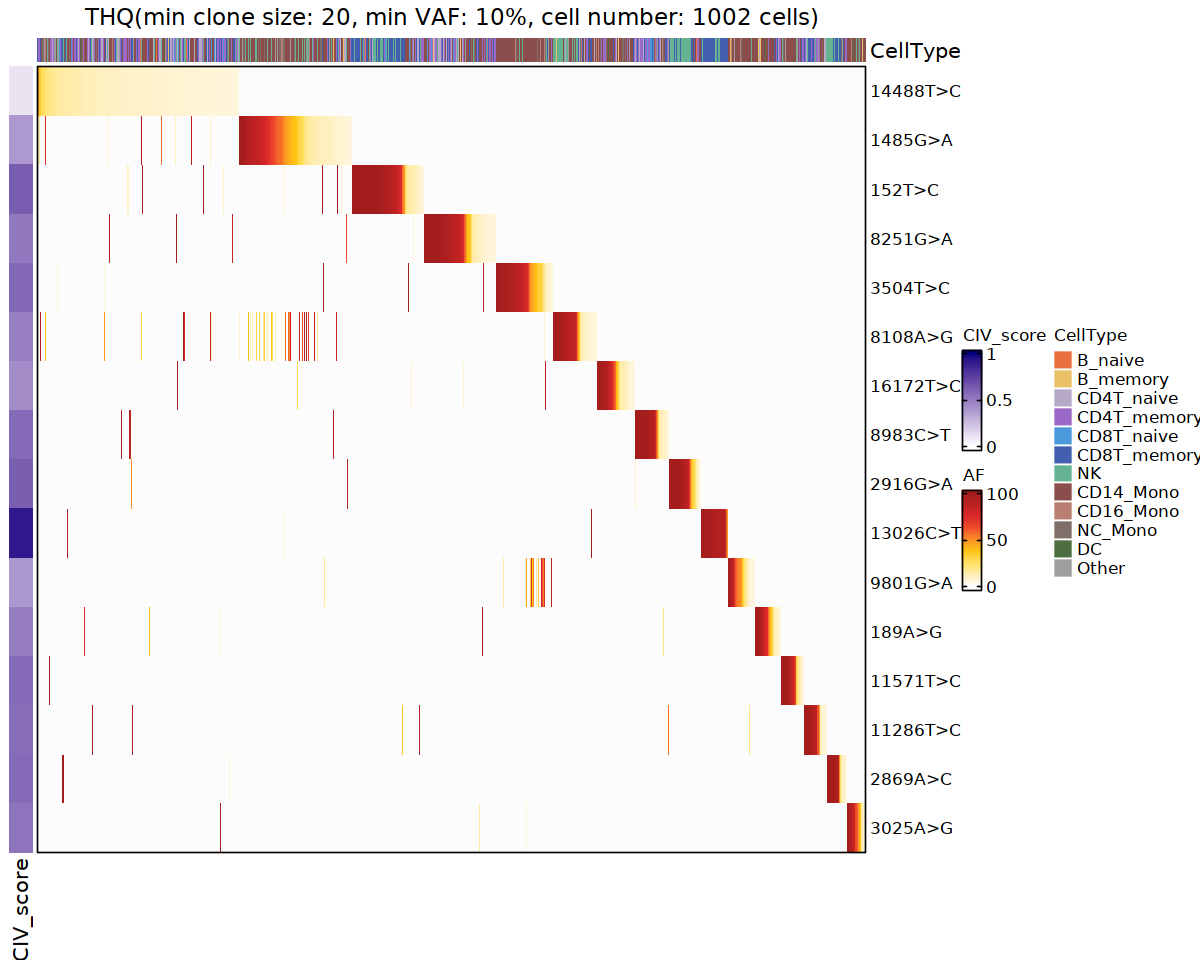

In [372]:
col_pal = colorRamp2(c(0, 1), c( "white", "navyblue"))
row_annot <- rowAnnotation(
  df = data.frame(CIV_score = sub_mv1_ls),
  col = list(CIV_score = col_pal), annotation_legend_param = list(border = "#000000"))

annot.tib = tibble(cell = colnames(new_plot_mat)) %>% left_join(meta.tib, by = "cell") %>% select(CellType)
ct_plot_df = data.frame(annot.tib)
new_ct = intersect(all_ct, unique(meta[common_cells, "CellType"]))
ct_plot_df$CellType = factor(ct_plot_df$CellType, levels = new_ct)
ha <- HeatmapAnnotation(df = ct_plot_df, col = list(CellType = ct_pal))
                                   
htmap_p = Heatmap(new_plot_mat, column_title = my_title, 
               col = colorRamp2(seq(0, 100, length.out = 9),
                                c("#FCFCFC","#FFEDB0","#FFDF5F","#FEC510","#FA8E24","#F14C2B","#DA2828","#BE2222","#A31D1D")),
               show_row_names = T,
               show_column_names = F,
               cluster_columns = F,
               cluster_rows = F,
               row_names_gp = gpar(fontsize = 10),
               name = "AF",
               heatmap_legend_param = list(border = "#000000", grid_height = unit(5, "mm")),
               top_annotation = ha,
                  left_annotation = row_annot,
               border = T,
               #width = unit(100, "mm"),
               #height = unit(100, "mm"),
               use_raster = T,
               raster_quality = 5)
htmap_p

heatmap_name = paste0(out_dir,"/CIV/",sample_name,"_CIV_heatmap.pdf")
pdf(heatmap_name, height = 2.645, width = 3.5)
htmap_p
dev.off()
message(paste0("CIV heatmaps have been saved to: ", heatmap_name))


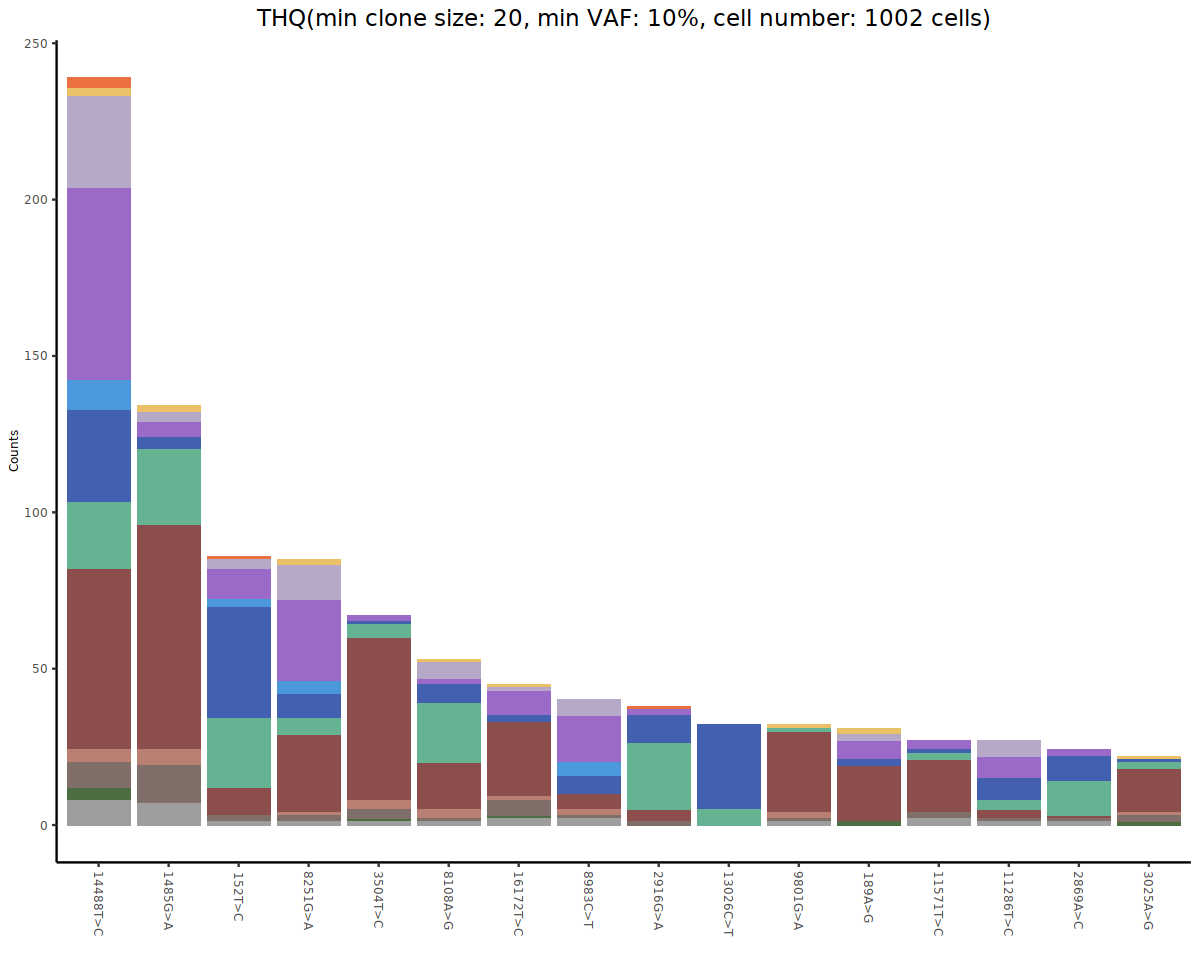

CIV heatmaps have been saved to: /syn1/wangxin/work/scATAC/PBMC/THQ/CIV/THQ_cellType_composition.pdf



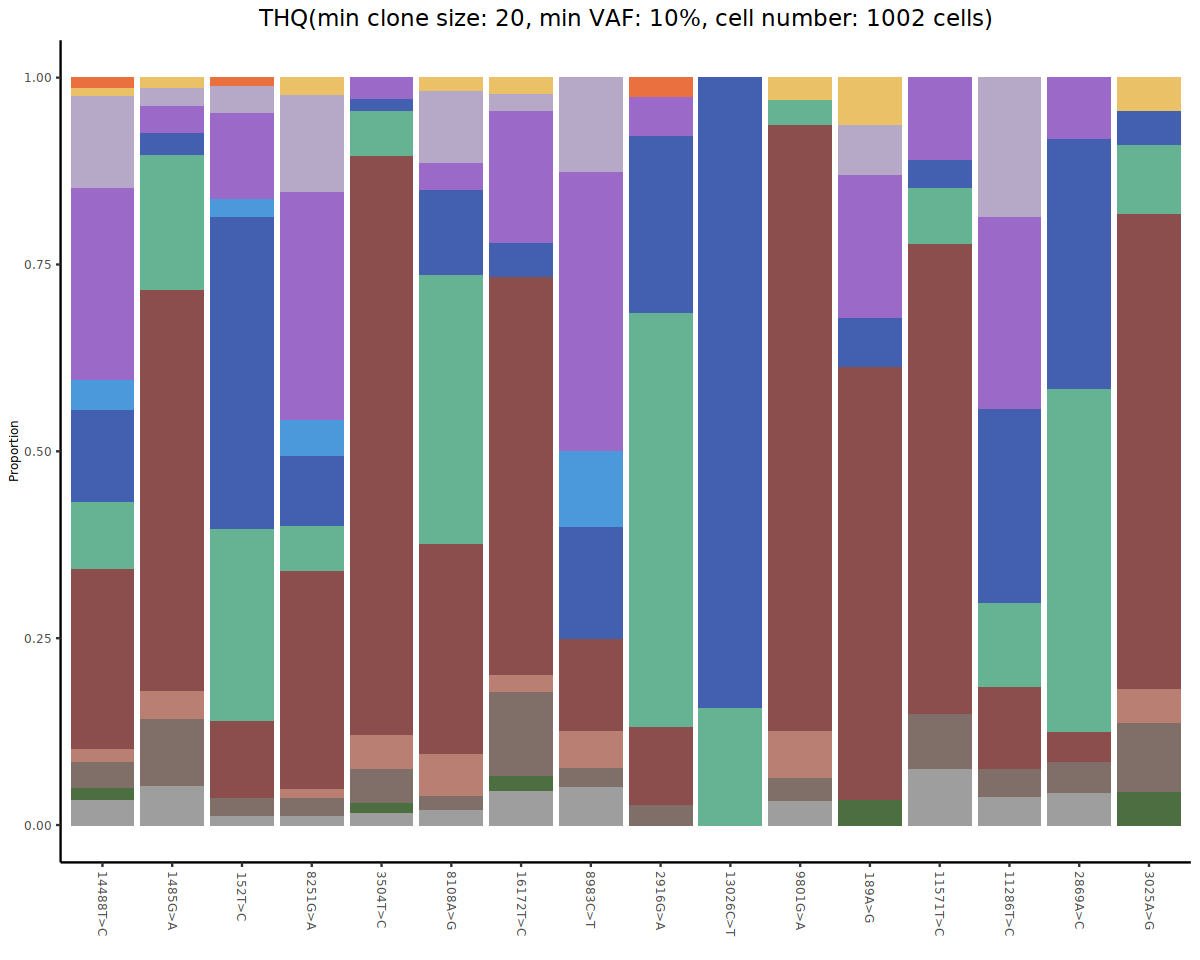

In [244]:

ct_df = data.frame(matrix(nrow=0, ncol=4)) 
for (i in rownames(new_plot_mat)) {
    pos_cells = clone_info_df[,"Cell"][clone_info_df$Clone == i]
    tmp_ct_df = as.data.frame(table(meta[pos_cells,"CellType"]))
    tmp_ct_df$Proportion = tmp_ct_df[,2]/sum(tmp_ct_df[,2])
    tmp_ct_df$Clone = i
    ct_df = rbind(ct_df, tmp_ct_df)
}
colnames(ct_df) = c("CellType", "Counts", "Proportion", "Clone")
ct_df$CellType = factor(ct_df$CellType, levels = new_ct)
ct_df$Clone = factor(ct_df$Clone, levels = rownames(new_plot_mat) )


p3 = ggplot(ct_df, aes(x=Clone, y=Counts, fill=CellType)) + geom_bar(stat = "identity") + labs(title = my_title) + theme_classic() +
        theme(plot.title=element_text(hjust=0.5), axis.text = element_text(size = 7), axis.title = element_text(size=7),
        axis.text.x = element_text(angle = 270, hjust = 0.1, vjust = 0.5), legend.position = "none") + scale_fill_manual(values=ct_pal) + xlab("")
p3
p4 = ggplot(ct_df, aes(x=Clone, y=Proportion, fill=CellType)) + geom_bar(stat = "identity") + labs(title = my_title) + theme_classic() +
        theme(plot.title=element_text(hjust=0.5), axis.text = element_text(size = 7), axis.title = element_text(size=7),
        axis.text.x = element_text(angle = 270, hjust = 0.1, vjust = 0.5), legend.position = "none") + scale_fill_manual(values=ct_pal) + xlab("")
p4
bar_name = paste0(out_dir,"/CIV/",sample_name,"_cellType_composition.pdf")
ggsave(p4, filename = bar_name, height = 2.5, width = 2)
message(paste0("CIV heatmaps have been saved to: ", bar_name))

In [187]:
out_dir

[1] "/syn1/wangxin/work/scATAC/PBMC/THQ"

In [375]:
nrow(umap_plot_df)

[1] 4607

CIV heatmaps have been saved to: /syn1/wangxin/work/scATAC/PBMC/THQ/CIV/THQ_umap.pdf



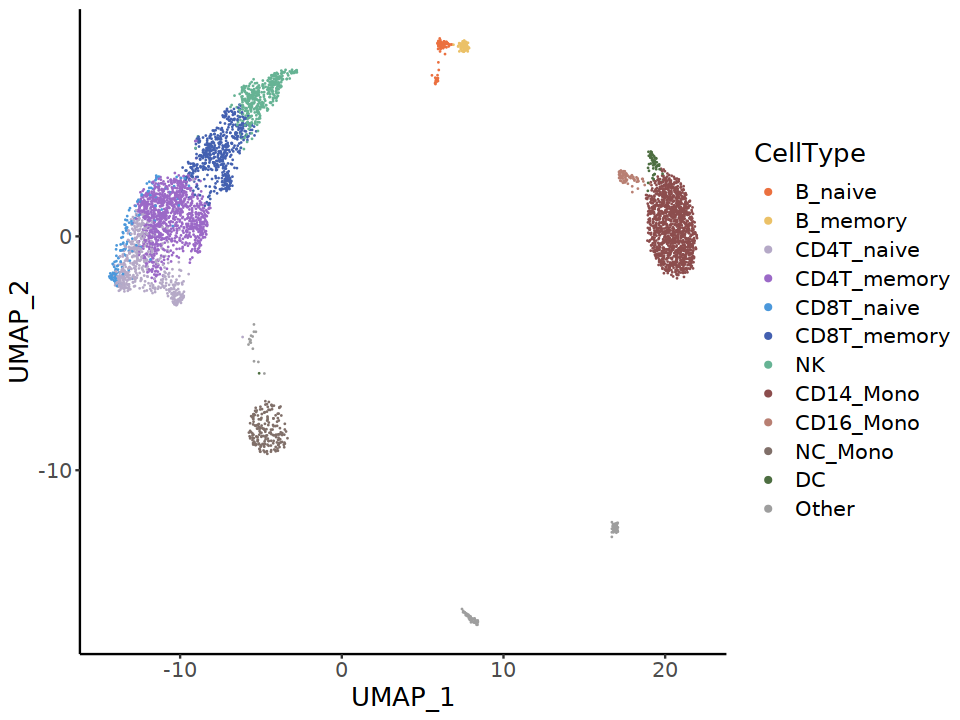

In [373]:
###here!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
options(repr.plot.width=8, repr.plot.height=6)

umap_plot_df = meta[colnames(af.dm),]
umap_plot_df$CellType = factor(umap_plot_df$CellType, levels = new_ct)
umap_p = ggplot(umap_plot_df, aes(x=UMAP_1, y=UMAP_2, color = CellType)) + geom_point(size=0.5, stroke = 0) + theme_classic() + scale_color_manual(values=ct_pal) + theme(text = element_text(size=15)) + 
    guides(colour = guide_legend(override.aes = list(size=2)))
umap_p
umap_pdf_name = paste0(out_dir,"/CIV/", sample_name,"_umap.pdf")
ggsave(umap_pdf_name, umap_p, height = 2.3, width = 4)
message(paste0("CIV heatmaps have been saved to: ", umap_pdf_name))

In [237]:
plot_ls=list()
for (i in rownames(new_plot_mat)) {
    cells = clone_info_df[clone_info_df$Clone == i, "Cell"]
    tmp_umap_df = umap_plot_df
    tmp_umap_df$VAF = 0
    tmp_umap_df[cells,"VAF"] = new_plot_mat[i, cells]
    tmp_umap_df$size = 0.4
    tmp_umap_df[cells,"size"] = 0.5
    #tmp_umap_df$trans = 0.3
    #tmp_umap_df[cells,"trans"] = 1
    tmp_umap_df = tmp_umap_df[order(tmp_umap_df$VAF),]
    plot_ls[[i]] = ggplot(tmp_umap_df, aes(x=UMAP_1, y=UMAP_2, color = VAF)) + geom_point(size=tmp_umap_df$size, stroke = 0) + scale_colour_gradient(low="gray", high ="red") + theme_classic() + scale_color_continuous(low="grey", high="red") + 
        theme(legend.position = "none") + labs(title = i)
    #plot_ls[[i]] = ggplot(tmp_umap_df, aes(x=UMAP1, y=UMAP2, color = VAF)) + geom_point(size=tmp_umap_df$size, alpha = tmp_umap_df$trans) + scale_colour_gradient(low="grey", high ="red") + theme_classic() + scale_color_continuous(low="grey", high="red") + 
    #    theme(legend.position = "none") + labs(title = i)
    #break
}
fn = paste0("/syn1/wangxin/work/scATAC/PBMC/",sample_name,"/CIV/pooled_umap_distribution_min_vaf_", vaf_cutoff, "_min_clone_", clone_size_cutoff,".pdf")
ggexport(plotlist = plot_ls, nrow = 5, ncol =5, filename = fn, width = 10, height = 10)

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is